In [3]:
from datetime import datetime, timezone, timedelta
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
# Gloabl seaborn Theme
sns.set_theme(style="whitegrid", palette="pastel")
import math
import import_ipynb
from evaluation import to_timestamp, request_influxdb, query_data, histplots, boxplots, lineplots, missing_data


In [4]:
# Load Tangaras
tangaras = pd.read_csv('../data/tangaras.csv')
tangaras.shape

(22, 7)

In [5]:
# Start Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
#start_timestamp = to_timestamp('2023-03-17T00:00:00-05:00')
start_timestamp = to_timestamp('2023-04-03T00:00:00-05:00')
# End Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
#end_timestamp = to_timestamp('2023-03-31T00:00:00-05:00')
end_timestamp = to_timestamp('2023-04-04T00:00:00-05:00')

print(f'Since: {start_timestamp} Until: {end_timestamp}')


Since: 1680498000000 Until: 1680584400000


In [6]:
# Query Data Sensors
query = query_data(tangaras, start_timestamp, end_timestamp)
print(query)

SELECT "name", last("pm25") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE0DD66') AND time >= 1680498000000ms AND time <= 1680584400000ms GROUP BY time(30s) fill(none); SELECT "name", last("pm25") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE0E752') AND time >= 1680498000000ms AND time <= 1680584400000ms GROUP BY time(30s) fill(none); SELECT "name", last("pm25") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE1260A') AND time >= 1680498000000ms AND time <= 1680584400000ms GROUP BY time(30s) fill(none); SELECT "name", last("pm25") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE94B1A') AND time >= 1680498000000ms AND time <= 1680584400000ms GROUP BY time(30s) fill(none); SELECT "name", last("pm25") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE965F2') AND time >= 1680498000000ms AND time <= 1680584400000ms GROUP BY time(30s) fill(none); SELECT "name", last("pm25") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DEBD89A') AND time >= 1680498000000ms AND time 

In [7]:
# Get Data Frame Sensors
def df_sensors(tangaras, start_timestamp, end_timestamp):
    # Data Frame Sensors
    df_sensors = []
    # SQL Query Data Sensors
    query = query_data(tangaras, start_timestamp, end_timestamp)
    # InfluxDB API REST Request
    influxdb_request = request_influxdb(query)
    #print(influxdb_request)
    #print(influxdb_request.text)

    # Data Frame InfluxDB Sensors
    df_influxdb_sensors = pd.read_csv(StringIO(influxdb_request.text), sep=",", low_memory=False)

    # Remove/Add Columns
    df_influxdb_sensors = df_influxdb_sensors[['time', 'name.1', 'last']]
    df_influxdb_sensors.rename(columns={'time': 'DATETIME', 'name.1': 'MAC', 'last': 'PM25'}, inplace=True)

    # Truncate Response
    for index, row in tangaras.iterrows():
        df_sensor = df_influxdb_sensors.loc[df_influxdb_sensors['MAC'] == row['MAC']].reset_index(drop=True)[['DATETIME', 'PM25']] # Warning
        if not df_sensor.empty:
            df_sensor.rename(columns={'PM25': row['ID']}, inplace=True)
            df_sensor.set_index('DATETIME', inplace=True)
            df_sensors.append(df_sensor)
    
    df_sensors = df_sensors[0].join(df_sensors[1:]).reset_index()

    # Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
    tz = timezone(timedelta(hours=-5))
    df_sensors['DATETIME'] = df_sensors['DATETIME'].apply(lambda x: datetime.fromtimestamp(int(x) / 1000, tz=tz).isoformat())

    df_sensors[df_sensors.columns.to_list()[1:]] = df_sensors[df_sensors.columns.to_list()[1:]].astype('float64')
    
    return df_sensors


In [8]:
# Data Frame Sensors
pm25_raw = df_sensors(tangaras, start_timestamp, end_timestamp)
pm25_raw.head()

,DATETIME,TANGARA_DD66,TANGARA_E752,TANGARA_260A,TANGARA_4B1A,TANGARA_65F2,TANGARA_D89A,TANGARA_1106,TANGARA_1282,TANGARA_14D6,...,TANGARA_2852,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_375E,TANGARA_F212,TANGARA_1712,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
0,2023-04-03T00:00:00-05:00,6.0,6.0,5.0,5.0,6.0,6.0,5.0,NaN,NaN,...,7.0,15.0,NaN,18.0,NaN,6.0,5.0,NaN,12.0,NaN
1,2023-04-03T00:00:30-05:00,6.0,6.0,NaN,4.0,6.0,7.0,5.0,12.0,11.0,...,10.0,15.0,8.0,18.0,6.0,NaN,NaN,0.0,11.0,25.0
2,2023-04-03T00:01:00-05:00,6.0,5.0,6.0,5.0,NaN,6.0,4.0,13.0,12.0,...,10.0,15.0,6.0,17.0,8.0,6.0,5.0,6.0,12.0,15.0
3,2023-04-03T00:01:30-05:00,6.0,5.0,6.0,4.0,6.0,6.0,4.0,14.0,12.0,...,8.0,14.0,5.0,17.0,11.0,5.0,5.0,5.0,13.0,15.0
4,2023-04-03T00:02:00-05:00,6.0,5.0,6.0,5.0,6.0,6.0,5.0,14.0,12.0,...,10.0,14.0,5.0,17.0,9.0,5.0,5.0,5.0,15.0,15.0


# Descriptive Statistics

In [9]:
# Describe Data
pm25_raw.describe()

,TANGARA_DD66,TANGARA_E752,TANGARA_260A,TANGARA_4B1A,TANGARA_65F2,TANGARA_D89A,TANGARA_1106,TANGARA_1282,TANGARA_14D6,TANGARA_1A1E,...,TANGARA_2852,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_375E,TANGARA_F212,TANGARA_1712,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
count,2763.000000,2676.000000,2652.000000,2670.000000,2662.000000,2671.000000,2660.000000,2748.000000,2699.000000,2268.000000,...,2715.000000,2650.000000,2742.000000,2758.000000,2695.000000,2677.000000,2674.000000,2735.000000,2734.000000,2728.000000
mean,9.721679,12.517190,13.502262,10.166292,13.773103,12.732684,9.992481,21.684498,16.374954,20.541887,...,17.473297,14.965283,12.667031,14.898477,18.989610,11.787075,11.233732,12.174771,14.455377,17.610337
std,6.024358,8.019094,8.681875,7.015696,8.835567,7.994126,7.018212,11.093826,33.379573,9.510077,...,6.884691,9.651981,10.601140,8.056150,7.738049,7.759815,7.479587,6.616533,8.305105,9.394792
min,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,4.000000,3.000000,7.000000,...,6.000000,3.000000,4.000000,5.000000,6.000000,3.000000,3.000000,0.000000,3.000000,5.000000
25%,4.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,11.000000,8.000000,12.000000,...,12.000000,6.000000,5.250000,8.000000,13.000000,5.000000,4.000000,6.000000,8.000000,9.000000
50%,7.000000,10.000000,11.000000,8.000000,10.000000,10.000000,8.000000,22.000000,13.000000,21.000000,...,17.000000,13.000000,7.000000,13.000000,19.000000,9.000000,9.000000,13.000000,14.000000,17.000000
75%,15.000000,19.000000,20.000000,15.000000,21.000000,19.000000,14.000000,30.000000,18.000000,25.000000,...,21.000000,19.000000,19.000000,20.000000,23.000000,17.000000,17.000000,17.000000,18.000000,25.000000
max,21.000000,55.000000,66.000000,60.000000,67.000000,61.000000,66.000000,96.000000,920.000000,138.000000,...,89.000000,57.000000,122.000000,37.000000,63.000000,57.000000,61.000000,48.000000,76.000000,45.000000


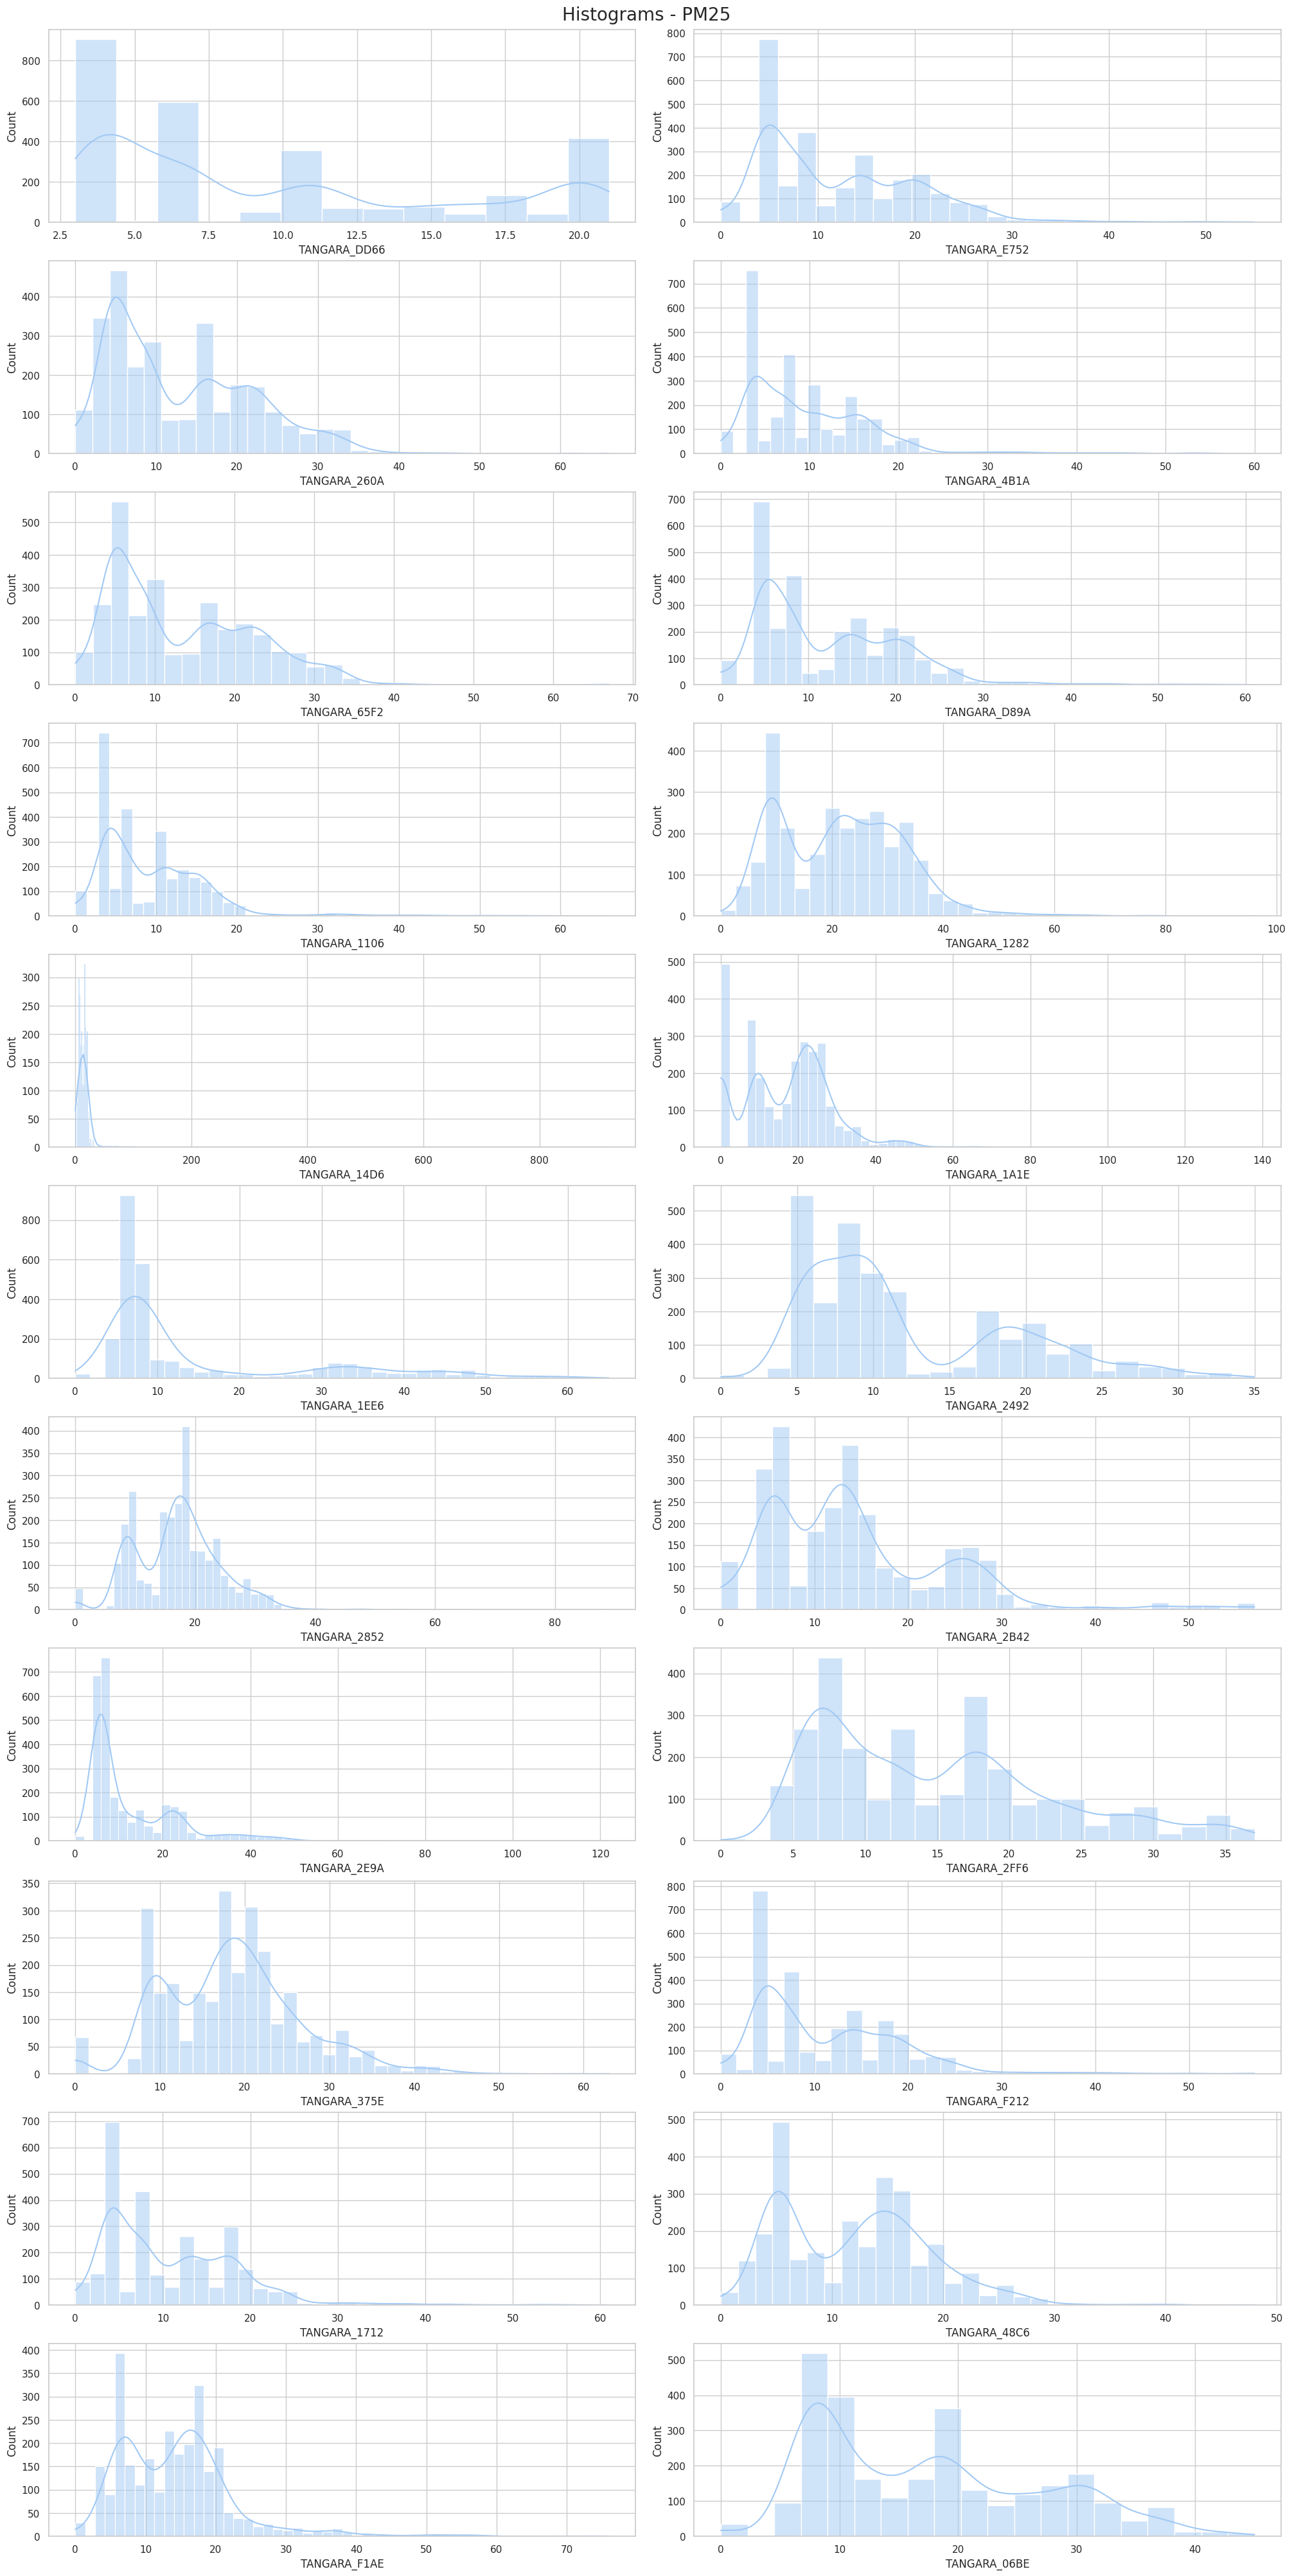

In [10]:
# Plot PM25 Histograms
histplots(pm25_raw)

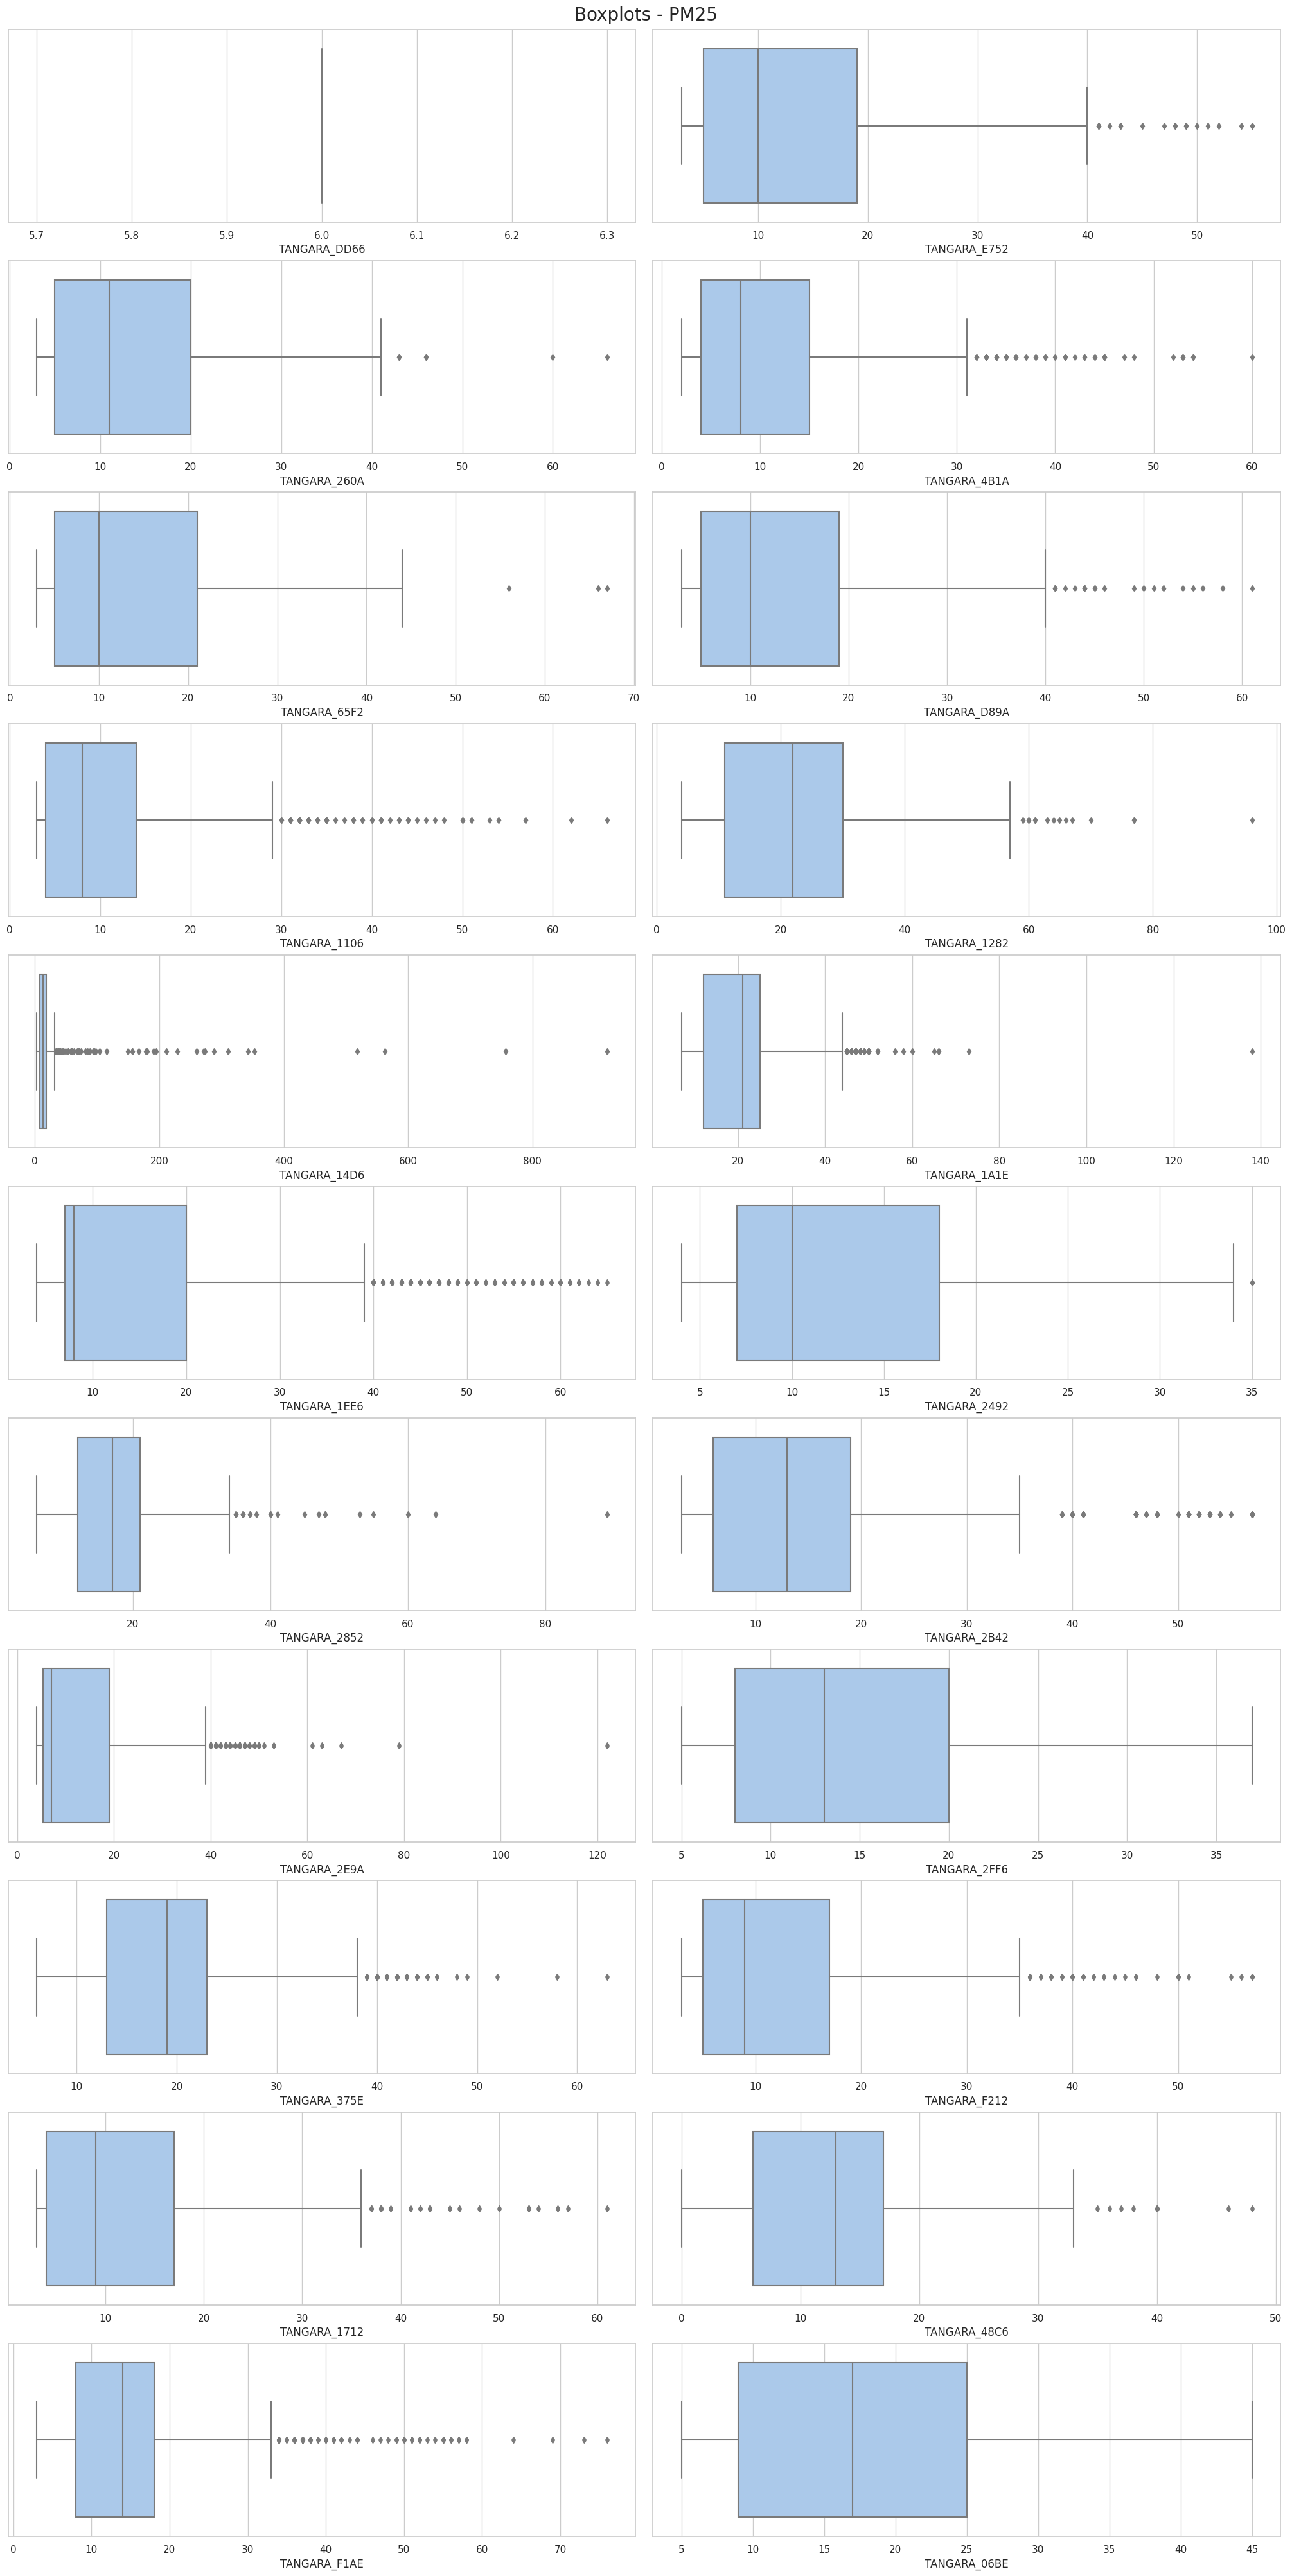

In [11]:
# Plot PM25 Boxplots
boxplots(pm25_raw)

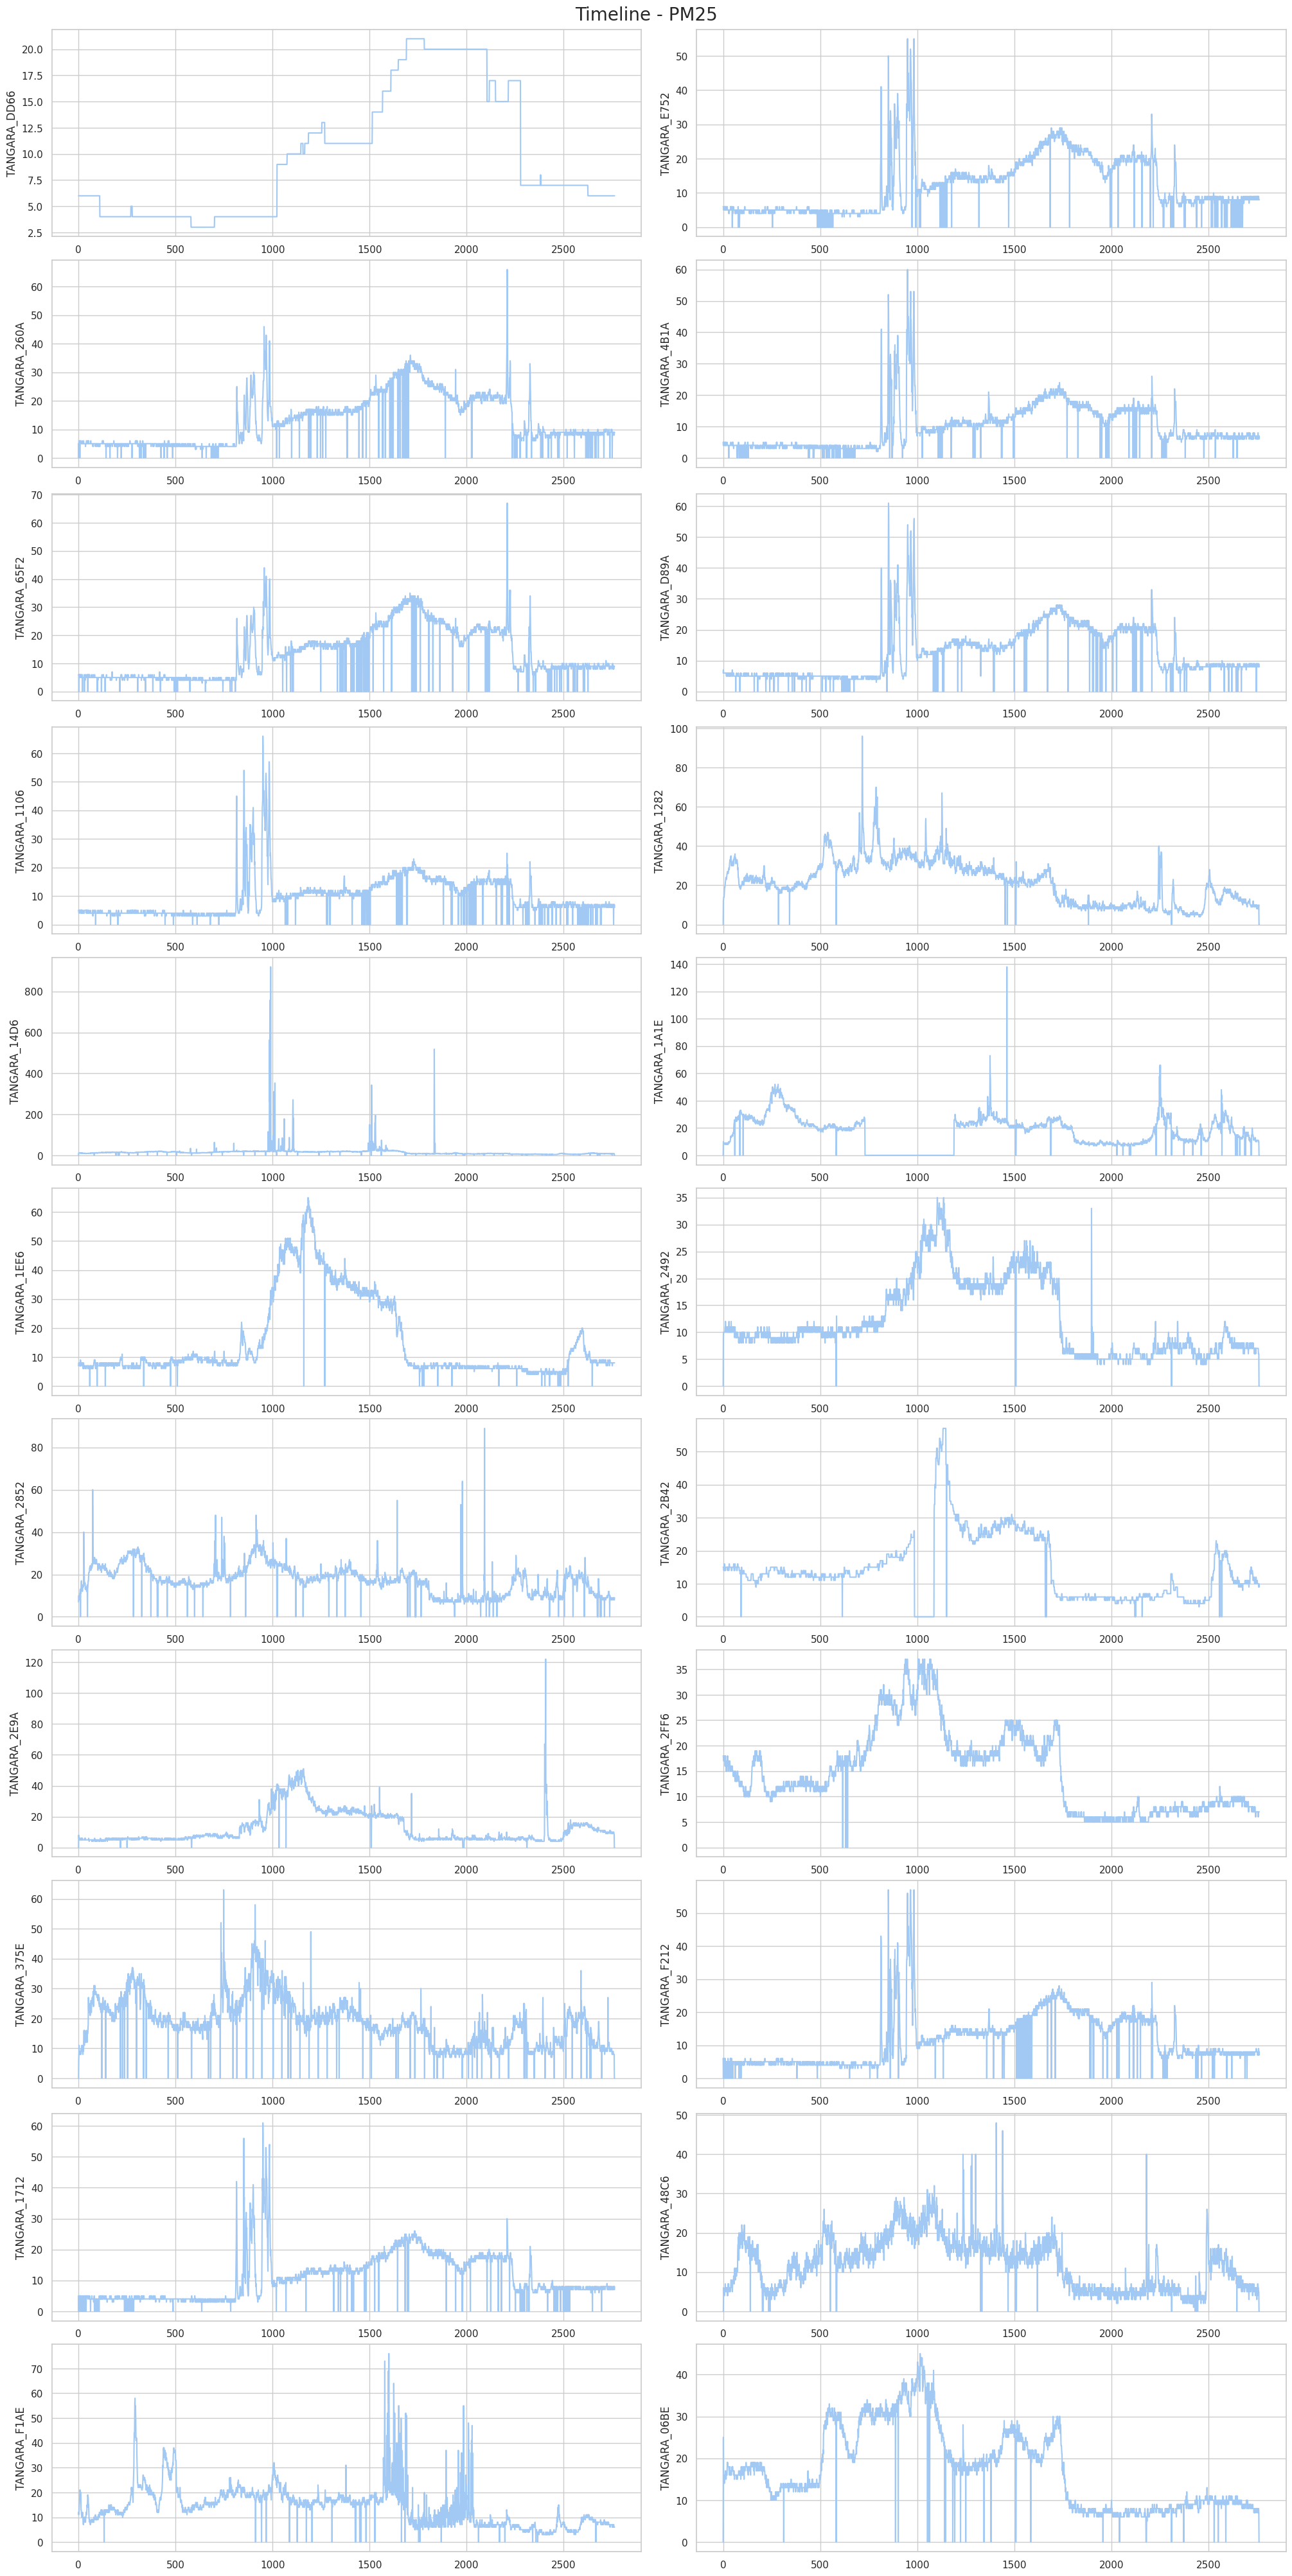

In [12]:
# Plot PM25 Lineplots
lineplots(pm25_raw)

In [13]:
# Evaluate Sensors
print(f'Total Sensors: {len(pm25_raw.columns[1:])}')
to_be_checked = missing_data(pm25_raw, 85)
print(f'To Be Checked: {len(to_be_checked)}')
to_be_checked

Total Sensors: 22
To Be Checked: 1


[{'ID': 'TANGARA_1A1E', 'Data': '82%', 'Missing': '18%'}]

In [14]:
# Save PM25 raw data into CSV file
pm25_raw.to_csv('../data/pm25_raw.csv', index=False)